<a href="https://www.kaggle.com/code/nicost312/two-branch-inception-v3?scriptVersionId=180543365" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import os
import cv2
import gc
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
from skimage import color
import json
from tensorflow.keras.preprocessing.text import Tokenizer
# test
# testing
# testing2
# from google.colab import files

2024-05-30 13:13:05.570510: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:13:05.570615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:13:05.685285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [30]:
print("TensorFlow version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TensorFlow version:  2.15.0
GPU is available


In [31]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [32]:
def split_data(dataset, train_size, valid_size, test_size):
  total_length = len(dataset)
  train_length = int(np.floor(total_length * train_size))
  valid_length = int(np.floor(total_length * valid_size))

  train_data = dataset.take(train_length)
  remaining = dataset.skip(train_length)
  valid_data = remaining.take(valid_length)
  test_data = remaining.skip(valid_length)

#   train_x = x[:train_breakpoint]
#   train_y = y[:train_breakpoint]
#   valid_x = x[train_breakpoint:valid_breakpoint]
#   valid_y = y[train_breakpoint:valid_breakpoint]
#   test_x = x[valid_breakpoint:]
#   test_y = y[valid_breakpoint:]

  return train_data, valid_data, test_data

In [33]:
def convert_to_lab(image):
    image = np.array(image)
    # OpenCV's 'cvtColor' function expects the input image to be in the BGR color space,
    # so we need to convert from RGB to BGR first
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Now we can convert from BGR to CIE L*a*b*
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)

    return image_lab

In [34]:
def preprocess_data(img, label, use_lab_color_space=True):
  img = tf.image.resize(img, (128, 128))
  img /= 255.

  if (use_lab_color_space):
    img = tf.py_function(func=color.rgb2lab, inp=[img], Tout=tf.float32)
    img = (img + [0, 128, 128]) / [100, 255, 255]
    
#     img = color.rgb2lab(img, channel_axis=2)
#     img[:, :, 0] = img[:, :, 0] / 100
#     img[:, :, 1:] = (img[:, :, 1:] + 128) / 255

  img.set_shape((128, 128, 3))
  label = tf.one_hot(label, depth=38)

  return img, label

In [35]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss'])) # How many epochs


    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

# PLANT VILLAGE

## Load Data

In [4]:
def load_images(filepath):
    images = []
    labels = []
    
    folds = os.listdir(filepath)
    for fold in folds:
        foldpath = os.path.join(filepath, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            image = cv2.imread(fpath)
            images.append(image)
            labels.append(fold)
        break
    return images, labels

In [5]:
path = '/kaggle/input/plantvillage-dataset/color'

images, labels = load_images(path)

In [6]:
print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')

print(images[0].shape)
print(labels[0])

Number of images: 1909
Number of labels: 1909
(256, 256, 3)
Tomato___Late_blight


In [19]:
def convert_to_lab(image):
    image = np.array(image)
    # OpenCV's 'cvtColor' function expects the input image to be in the BGR color space,
    # so we need to convert from RGB to BGR first
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Now we can convert from BGR to CIE L*a*b*
    image_lab = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2Lab)
    
    return image_lab

In [74]:
def preprocess_data(images, labels, use_lab_color_space=True):
     # resize
    images = tf.image.resize(images, (128, 128))
    images /= 255.
    
    # convert to lab color space
    if (use_lab_color_space):
        img = tf.py_function(func=color.rgb2lab, inp=[images], Tout=tf.float32)
        img = (img + [0, 128, 128]) / [100, 255, 255]
  
    # get unique labels
    unique_labels = np.unique(labels)
    # create a mapping from labels to integers
    label_map = dict((l, i) for i, l in enumerate(unique_labels))
    # convert labels to integers
    labels = np.array([label_map[l] for l in labels])
    # one-hot encode labels
    labels = tf.one_hot(labels, depth=unique_labels.shape[0])
    
    return images, labels

In [75]:
# get 50 first images
images = images[:50]
labels = labels[:50]

images_preprocessed, labels_preprocessed = preprocess_data(images, labels)

In [76]:
print(images_preprocessed.shape)
print(labels_preprocessed.shape)

(50, 128, 128, 3)
(50, 1)


In [77]:
# show image ab channel
lab_channel = images_preprocessed[0]

a_channel = lab_channel[:, :, 1]
b_channel = lab_channel[:, :, 2]
l_channel = lab_channel[:, :, 0]

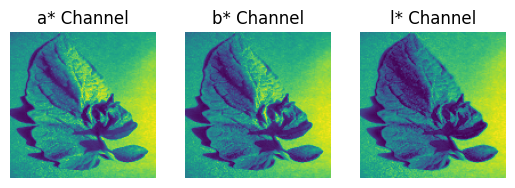

In [78]:
 # Display the a* channel
plt.subplot(1, 3, 1)
plt.imshow(a_channel)
plt.title('a* Channel')
plt.axis('off')  # Hide the axes

# Display the b* channel
plt.subplot(1, 3, 2)
plt.imshow(b_channel)
plt.title('b* Channel')
plt.axis('off')  # Hide the axes

# Display the l* channel
plt.subplot(1, 3, 3)
plt.imshow(l_channel)
plt.title('l* Channel')
plt.axis('off')  # Hide the axes

plt.show()

End input

In [ ]:
# Construct a tf.data.Dataset
dataset, ds_info = tfds.load('plant_village',
              split="train",
              with_info=True,
              shuffle_files=True,
              as_supervised=True)

In [ ]:
dataset.shuffle(500)

In [ ]:
print(len(dataset))

In [ ]:
tfds.show_examples(dataset, ds_info)

In [ ]:
dataset = dataset.map(preprocess_data)

In [ ]:
iterator = iter(dataset)
test= next(iterator)

# Search for data with early blight condition
if (np.argmax(test[1]) != 19):
    test = next(iterator)
    
test = np.copy(test[0])

l_channel = test[:, :, 0]

ab_channel = test[:, :, 1:]
ones_array = np.zeros((ab_channel.shape[0], ab_channel.shape[1], 1))
ab_channel = np.concatenate((ones_array, ab_channel), axis=2)
ab_channel = (ab_channel * [100, 255, 255] - [0, 128, 128]) * [0, 255, 255]
print(ab_channel[0][0])
ab_channel = color.lab2rgb(ab_channel)

print(ab_channel[0][0])

# Plot the image
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5)
axs[0].imshow(l_channel, cmap='gray')
axs[0].set_title('L Channel')
axs[1].imshow(ab_channel)
axs[1].set_title('AB Channel')

# Show the plot
plt.show()

In [ ]:
train_data, valid_data, test_data = split_data(
    dataset=dataset,
    train_size=0.6,
    valid_size=0.2,
    test_size=0.2
  )

In [ ]:
print(len(train_data), len(valid_data), len(test_data))

In [ ]:
train_data = train_data.batch(32)
valid_data = valid_data.batch(32)

# TWO BRANCH INCEPTION V3

In [ ]:
module_filters = [
    [64, 48, 64, 64, 96, 96, 32],
    [64, 48, 64, 64, 96, 96, 64],
    [64, 48, 64, 64, 96, 96, 64],
    [192, 128, 128, 192, 128, 128, 128, 128, 192, 192],
    [192, 160, 160, 192, 160, 160, 160, 160, 192, 192],
    [192, 160, 160, 192, 160, 160, 160, 160, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [192, 192, 192, 192, 192, 192, 192, 192, 192, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
    [320, 384, 384, 384, 448, 384, 384, 384, 192],
]

In [ ]:
class CopyChannels(tf.keras.layers.Layer):
    """
    This layer copies channels from channel_start the number of channels given in channel_count.
    """
    def __init__(self,
                 channel_start=0,
                 channel_count=1,
                 **kwargs):
        self.channel_start=channel_start
        self.channel_count=channel_count
        super(CopyChannels, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.channel_count)

    def call(self, x):
        return x[:, :, self.channel_start:(self.channel_start+self.channel_count)]

    def get_config(self):
        config = {
            'channel_start': self.channel_start,
            'channel_count': self.channel_count
        }
        base_config = super(CopyChannels, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, name=None):
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(scale=False)(x)
    return tf.keras.layers.Activation('relu')(x)

In [ ]:
def inception_module_1(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], 3)

  t3 = conv2d_bn(x, filters[3], 1)
  t3 = conv2d_bn(t3, filters[4], 3)
  t3 = conv2d_bn(t3, filters[5], 3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[6], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [ ]:
def inception_module_2(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2 = conv2d_bn(t2, filters[2], (1,7))
  t2 = conv2d_bn(t2, filters[3], (7,1))

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], (1,7))
  t3 = conv2d_bn(t3, filters[6], (7,1))
  t3 = conv2d_bn(t3, filters[7], (1,7))
  t3 = conv2d_bn(t3, filters[8], (7,1))

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[9], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [ ]:
def inception_module_3(x, filters):
  t1 = conv2d_bn(x, filters[0], 1)

  t2 = conv2d_bn(x, filters[1], 1)
  t2_1 = conv2d_bn(t2, filters[2], (1,3))
  t2_2 = conv2d_bn(t2, filters[3], (3,1))
  t2 = tf.keras.layers.concatenate([t2_1, t2_2], axis=3)

  t3 = conv2d_bn(x, filters[4], 1)
  t3 = conv2d_bn(t3, filters[5], 1)
  t3_1 = conv2d_bn(t3, filters[6], (1,3))
  t3_2 = conv2d_bn(t3, filters[7], (3,1))
  t3 = tf.keras.layers.concatenate([t3_1, t3_2], axis=3)

  t4 = tf.keras.layers.MaxPooling2D(3, strides=1, padding='same')(x)
  t4 = conv2d_bn(t4, filters[8], 1)

  return tf.keras.layers.concatenate([t1, t2, t3, t4], axis=3)

In [ ]:
def two_path_inception_v3(
                include_top=True,
                include_first_block=True,
                weights=None, #'two_paths_plant_leafs'
                input_shape=(128,128,3),
                pooling=None,
                classes=38,
                two_paths_partial_first_block=0,
                two_paths_first_block=False,
                l_ratio=0.2,
                ab_ratio=0.8,
                max_mix_idx=10,
                model_name='two_path_inception_v3',
                **kwargs):

    img_input = tf.keras.layers.Input(shape=input_shape)

    if include_first_block:
        if two_paths_first_block:
            if (l_ratio>0):
                l_branch = CopyChannels(0,1)(img_input)
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), strides=(2, 2), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(32*l_ratio)), (3, 3), padding='valid')
                l_branch = conv2d_bn(l_branch, int(round(64*l_ratio)), (3, 3))
                l_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(l_branch)

            if (ab_ratio>0):
                ab_branch = CopyChannels(1,2)(img_input)
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), strides=(2, 2), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(32*ab_ratio)), (3, 3), padding='valid')
                ab_branch = conv2d_bn(ab_branch, int(round(64*ab_ratio)), (3, 3))
                ab_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(ab_branch)

            if (l_ratio>0):
                if (ab_ratio>0):
                    x = tf.keras.layers.Concatenate(axis=3, name='concat_first_block')([l_branch, ab_branch])
                else:
                    x = l_branch
            else:
                x = ab_branch
        else:
            single_branch = conv2d_bn(img_input, 32, (3, 3), strides=(2, 2), padding='valid')
            single_branch = conv2d_bn(single_branch, 32, (3, 3), padding='valid')
            single_branch = conv2d_bn(single_branch, 64, (3, 3))
            single_branch = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(single_branch)
            # print('single path first block')
            x = single_branch

    if max_mix_idx >= 0:
        for i in range(max_mix_idx):
          if i < 3:
            x = inception_module_1(x, module_filters[i])
          elif i < 8:
            x = inception_module_2(x, module_filters[i])
          else:
            x = inception_module_3(x, module_filters[i])

    if include_top:
        # Classification block
        x = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = tf.keras.layers.GlobalMaxPooling2D()(x)

    inputs = img_input
    # Create model.
    model = tf.keras.models.Model(inputs, x, name=model_name)
    return model

# EXPERIMENTS

In [ ]:
print("Train data shape:", tf.data.experimental.cardinality(train_data).numpy())
print("Valid data shape:", tf.data.experimental.cardinality(valid_data).numpy())

In [ ]:
# Inspect the shape of one element of train_data
for image, label in train_data.take(5):
    print("Image shape:", image.shape)
    print("Label shape:", label.shape)
    

In [ ]:
model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
        metrics=['accuracy'])

In [ ]:
monitor='val_accuracy'
epochs=10

history = model.fit(
    train_data,
    verbose=1,
    epochs=epochs,
    validation_data=valid_data
)

In [ ]:
plot_loss_curves(history)